# Data Analysis for Intent Expressions Around COVID-19 Vaccine Hesitancy

## Introduction
The COVID-19 pandemic has been a global health crisis of unprecedented scale, affecting millions of people worldwide. With the emergence of vaccines, there is hope that the pandemic can be controlled and eventually ended. However, vaccine hesitancy has emerged as a significant challenge in achieving herd immunity and ending the pandemic. As defined in [Wikipedia](https://en.wikipedia.org/wiki/Vaccine_hesitancy), vaccine hesitancy is a delay in acceptance, or refusal, of vaccines despite the availability of vaccine services and supporting evidence. Understanding the reasons behind vaccine hesistancy has becoming increasingly significant in controlling the spread of the virus and saving lives. 

In this notebook, we will explore and analyse the dataset of people's intent expressions around COVID-19 vaccine hesitancy and bring insight into people's main concerns about COVID-19 vaccines. This could help public health officials to develop targeted communication and education strategies that address concerns and promote vaccine acceptance. 

The dataset used in the notebook come from the Vaccination Information Resource Assistant (VIRA) Coversation Corpus. For the context, [VIRA](https://vaxchat.org/) is a chatbot developed by he Johns Hopkins International Vaccine Access Center aiming to address the COVID-19 hesitancy. Thanks to Gretz et al. (2022) who made the dataset available to the public.

## Load the data

First of all, let's load the dataset into a dataframe with the **pandas** package. To ensure we have enough data to explore and analyse, the data in the csv files below are combined into one dataset.
- train_23.csv
- set_23.csv
- dev_23.csv

In [1]:
# Set warnings to "ignore" to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/amyyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amyyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read the data from csv files for intent expression and trust (Note:The files are read locally. The folder paths could be varied from your side.)
df_intent_train=pd.read_csv('./datasets/IBM_Debater_(R)_Intent_expressions/train_23.csv')
df_intent_test=pd.read_csv('./datasets/IBM_Debater_(R)_Intent_expressions/test_23.csv')
df_intent_dev=pd.read_csv('./datasets/IBM_Debater_(R)_Intent_expressions/dev_23.csv')

In [4]:
# concatate the train, test and dev sets into one datafame named 'intent expression' 
df_intent=pd.concat([df_intent_train,df_intent_test,df_intent_dev],axis=0,ignore_index=True)

## Data exploration and analysis

### Initial data exploration

Once the data is loaded and saved into a dataframe, we perform the initial data exploration such as displaying the first few rows, checking the missing values with the summary, showing the number of unique values in each column etc.

In [5]:
# display first 5 rows
df_intent.head()

,sentence,label,label_idx
0,Do booster shots have side effects worsen than...,Are booster shot side effects worse than those...,175
1,the vaccine has side effects?,Are booster shot side effects worse than those...,175
2,booster vaccine leaves worse side effects than...,Are booster shot side effects worse than those...,175
3,are reinforcements safe?,Are booster shot side effects worse than those...,175
4,because the second dose of the covid-19 vaccin...,Are booster shot side effects worse than those...,175


To display all the words in the column of 'sentence' and 'label', the `style.set_properties()` is used. 

In [6]:
# display the first 5 rows with wider column width
# credit: https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
df_intent.head().style.set_properties(subset=['sentence'], **{'width': '400px'})

,sentence,label,label_idx
0,Do booster shots have side effects worsen than the second shot ?,Are booster shot side effects worse than those from the second shot?,175
1,the vaccine has side effects?,Are booster shot side effects worse than those from the second shot?,175
2,booster vaccine leaves worse side effects than first and second doses,Are booster shot side effects worse than those from the second shot?,175
3,are reinforcements safe?,Are booster shot side effects worse than those from the second shot?,175
4,because the second dose of the covid-19 vaccine is higher in side effects,Are booster shot side effects worse than those from the second shot?,175


In [7]:
# display the column summary.
df_intent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   7972 non-null   object
 1   label      7972 non-null   object
 2   label_idx  7972 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 187.0+ KB


The summary above tells us that the dataset is made up of 7972 rows and 3 columns. Since each column has 7972 values, there are no missing values in any column. Both the columns of 'sentence' and 'label' are categorical variables and the column 'label_idx' is numberical variable.

Within all the intent expressions, can we know how many intent expressions/sentences and common questions we have in the dataset?

In [8]:
# diplay the number of distinct values in each column
df_intent.nunique()

sentence     7971
label         181
label_idx     181
dtype: int64

It can be seen that there are 7971 expresssiona and 181 common questions in total. As the data has 7972 rows but returns 7971 unique expressions, there must be one duplicate expression. But which expression is duplicated?

Using the codes below, we find the sentence 'How long am I immune?' appears twice and is labelled as the common question 'How long does the immunity from the vaccine last?' and 'How long am I immune from COVID-19 if I had the virus?' respectively.

In [9]:
# identify the duplicated sentence
df_intent[df_intent['sentence'].duplicated()].style.set_properties(subset=['sentence'], **{'width': '200px'})

,sentence,label,label_idx
6801,How long am I immune?,How long am I immune from COVID-19 if I had the virus?,128


In [10]:
# display the duplicated sentence and its labels
df_intent[df_intent['sentence']=='How long am I immune?'].style.set_properties(subset=['sentence'], **{'width': '200px'})

,sentence,label,label_idx
1823,How long am I immune?,How long does the immunity from the vaccine last?,92
6801,How long am I immune?,How long am I immune from COVID-19 if I had the virus?,128


### Data analysis on common questions

Based on the initial data exploration, we know there are 181 unique questions in total. These questions are most likely to reflect people's concerns or queries about COVID-19 vaccines. In term of the concerns or queries, we are interested in whether any question has significantly higher number of expressions compared to others. 

Let's count the number of expressions/sentences for each question and visualise the result in a histogram.

In [11]:
# Count the number of sentences by label
q_count=df_intent.groupby(['label','label_idx'],as_index=False).agg({'sentence':'count'})

Text(0.5, 1.0, 'Distribution for Sentence Count')

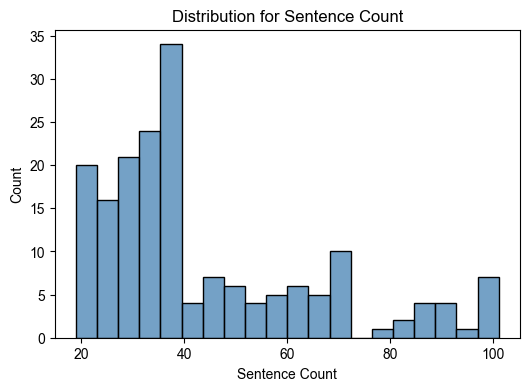

In [12]:
# display the distribution for sentence count with a histogram
f,ax=plt.subplots(figsize=(6,4))
sns.histplot(data=q_count,x='sentence',bins=20,color='steelblue')
sns.set_theme(style="white")
plt.xlabel('Sentence Count')
plt.title("Distribution for Sentence Count")

It is interesting to find that common questions are separated into three groups by number of sentences:
- Over 50% of questions have 20-40 intent expressions;
- Around 25% of questions have 40-80 intent expressions;
- For the remaining questions, the number of expressions is remarkably higher than the other two groups and can be as high as 100.

We are curious about which questions have the most sentences. To find this out, the top 10 common questions are displayed as below.

In [13]:
# capture the top 10 common questions in terms of sentence count and saved into variable named 'q_count_top10'
q_count_top10=df_intent.groupby(['label','label_idx'],as_index=False).count().sort_values(by='sentence',ascending=False).head(10)

Text(0, 0.5, '')

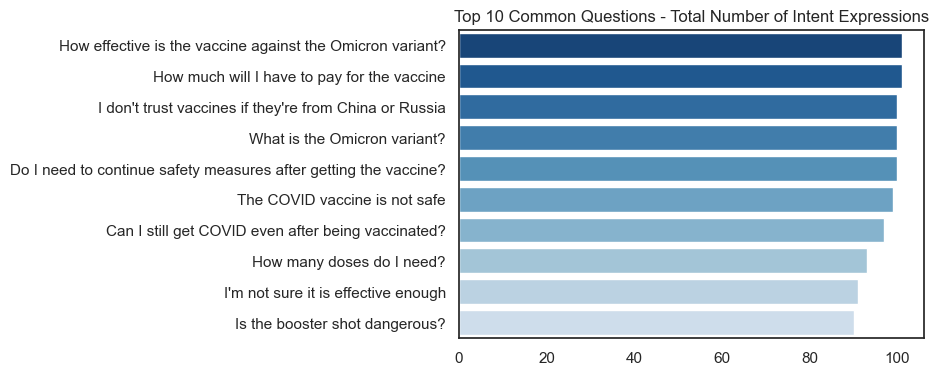

In [14]:
# display the bar chart for top 10 questions
f,ax=plt.subplots(figsize=(6,4))
color_palette = sns.color_palette("Blues_r", n_colors=len(q_count_top10)+2) # use a reversed sequential color palette for the bar chart
sns.barplot(data=q_count_top10,x='sentence',y='label',palette=color_palette)
sns.set_theme(style="white")
plt.title ('Top 10 Common Questions - Total Number of Intent Expressions')
plt.xlabel('')
plt.ylabel('')

As shown in the chart above, each of the top 10 common questions has 90-100 intent expressions and they are related to several concerns or queries such as
- effectiveness of the vaccine
- cost of the vaccine
- mistrust of vaccines which are from China or Russia
- lack of knowledge in Omicron variant
- safety meatures after getting the vaccine
- safety risks of the vaccine (including booster shot)
- doses of the vaccine

What about the length of each intent expression? How many words are included in one expression/sentence?

Let's create the new column `word_count` and explore the distribution of word count with a histogram.

In [15]:
# create new column named 'word_count' in the dataframe
df_intent['word_count']=df_intent['sentence'].apply(lambda x:len(x.split()))

Text(0.5, 1.0, 'Distribution for Word Count')

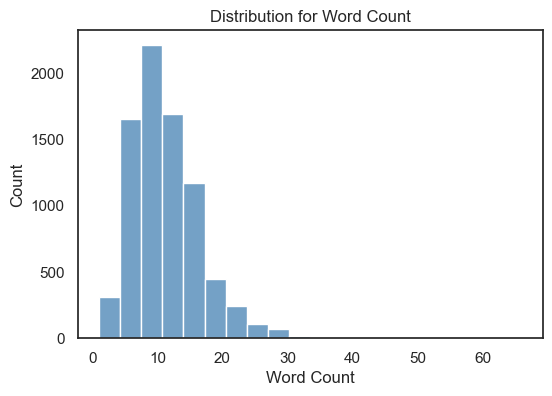

In [16]:
# display the distribution for word count
f,ax=plt.subplots(figsize=(6,4))
sns.histplot(data=df_intent,x='word_count',bins=20,color='steelblue')
sns.set_theme(style="white")
plt.xlabel('Word Count')
plt.title("Distribution for Word Count")

As shown in the graph above, the word length of an intent expressions can range from 1 to over 60. Most of expressions have a word length between 5 and 15. There are a small number of expressions having a word length over 30.

Can we know how many expressions have more than 30 words? What are the top 3 expressions with the most words?

In [17]:
# count the expressions with over 30 words
df_intent[df_intent['word_count']>30].shape[0]

46

In [18]:
# display the top 3 expressions with highest word count
df_intent.nlargest(3,'word_count').style.set_properties(subset=['sentence'], **{'width': '300px'})

,sentence,label,label_idx,word_count
2929,"Make sure you understand and comply with all the requirements of the airline and your destination country regarding travel, screening or quarantine, which may differ from the requirements of the United States. If you do not meet the requirements of your duty station, you may be denied entry and must return to the United States. Check the current situation of COVID-19 in your country of destination.",Is it okay for me to travel internationally if I'm vaccinated?,107,66
3750,"The fear that a vaccine will somehow change your DNA is one we've seen aired regularly on social media. The BBC asked three independent scientists about this. They said that the coronavirus vaccine would not alter human DNA. Some of the newly created vaccines, including the one now approved in the UK developed by Pfizer/BioNTech, use a fragment of the virus's genetic",They will put a chip/microchip to manipulate me,26,62
6377,"Vaccination is one of the most effective public health interventions in the world for saving lives and promoting good health. Only clean water, which is considered to be a basic human right, performs better. Despite this, uptake of vaccines has reduced in some countries and this is thought to be partly caused by misguided concerns over vaccine safety.",The vaccine should not be mandatory,24,58


It is found that 46 expressions have a word length over 30. The top 3 expressions are related to the concerns below:
- Some vaccines do not meet requirement of destination country during international travel (66 words).
- The vaccine is likely to change our DNA (62 words).
- The vaccine should not be mandatory (58 words).

What about the total number of words by common questions? Are there any questions that people tend to express more?

Let's sum up the word count in expressions for each labelled question and visualise the top 10 questions with the largest amount of words in a bar chart.

In [19]:
# extract the top 10 questions and save in the new variable 'w_count_top10'
w_count_top10=df_intent.groupby(['label','label_idx'],as_index=False).agg({'word_count':'sum'}).sort_values(by='word_count',ascending=False).head(10)

Text(0, 0.5, '')

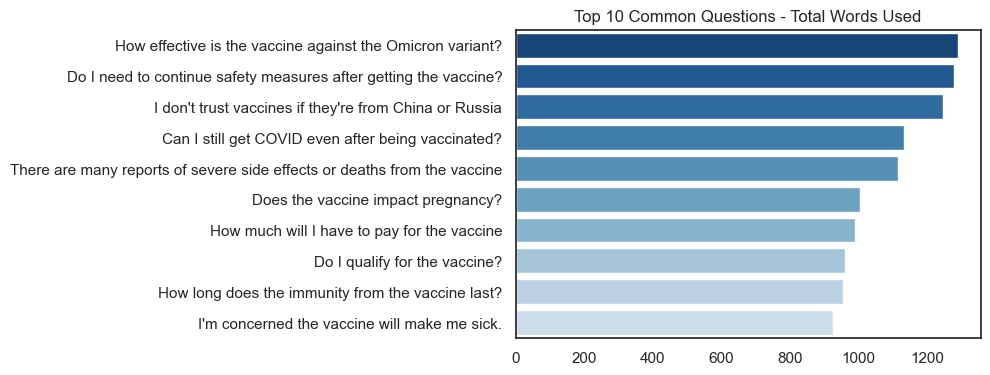

In [20]:
# display the top 10 questons with a bar chart
f,ax=plt.subplots(figsize=(6,4))
color_palette1=sns.color_palette("Blues_r", n_colors=len(w_count_top10)+2)
sns.barplot(data=w_count_top10,x='word_count',y='label',palette=color_palette1)
sns.set_theme(style="white")
plt.title ('Top 10 Common Questions - Total Words Used')
plt.xlabel('')
plt.ylabel('')

By looking at the total words used in the top 10 common questions, the following findings are discovered:
- Within the top 10 questions, six of them cover the same concerns or queries identified previously including effectiveness of the vaccine, safety meatures after getting the vaccine, mistrust of vaccines which are from China or Russia and cost of the vaccine. 
- Several other concerns also draw our attention including side effects from the vaccine (such as death, sickness, impact on pregnancy) and eligibility for the vaccine. 

### Data analysis on key topics or main concerns

We have looked at the top 10 common questions individually either by count of intent expressions or total lengths of words used. What about the relationships of these questions? Do several of them talk around the same topics or concerns?

In the following, we will extract the most frequently used words in the common questions to identify the key topics or main concerns.

In [21]:
# Make a new copy of df_intent and named 'df_intent_copy'
df_intent_copy=df_intent.copy()

In [22]:
# combine the text in the column of 'label' and save it as 'text'
text = " ".join(i for i in df_intent_copy['label'])

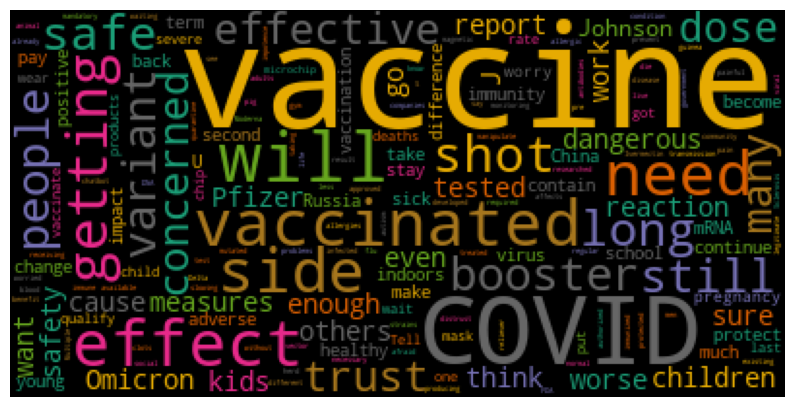

In [23]:
# display the word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=200, collocations = False,colormap='Dark2').generate(text)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('word_cloud.png')
plt.show()

From the word cloud, we notice that the most frequent words are stopwords and less informative words (such as vaccine, covid, need etc). Let's try recalculate frequencies after performing some data cleaning. 

In [24]:
# create the function 'text_cleaning' which include multiple steps of text data cleaning

def text_cleaning (a:str,b:str,data:pd.DataFrame):
    # Split the column 'a' into a list of words and create a new column named 'b'
    data[b]=data[a].apply(lambda x: x.split())
    # Set the lower case for the word
    data[b]=data[b].apply(lambda x: [t.lower() for t in x])
    # Remove the punctuation
    data[b]=data[b].apply(lambda x: [t.replace('?','').replace(',','') for t in x])
    # Remove the non-alphabatic or non-number
    data[b]=data[b].apply(lambda x: [t for t in x if t.isalnum()])
    
    # Lemmatization
    import nltk
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    from nltk.stem import WordNetLemmatizer 

    # Init the Wordnet Lemmatizer
    wnl = WordNetLemmatizer()
    data[b]=data[b].apply(lambda x: [wnl.lemmatize(t,'v') for t in x ])

    #Set up stop words for removal
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    #stopwords
    stop_words=stopwords.words("english")

    #Add custom stopwords to the list
    stop_words.extend(["vaccine","still","covid","vaccines","vaccinate","vaccination","need"])

    # Remove the stop_words
    data[b]=data[b].apply(lambda x: [word for word in x if not word in stop_words])

    # Join the words
    data[b]=data[b].apply(lambda x: " ".join(x))

    return data


In [25]:
# apply the function and save the cleaned dataframe as 'df_intent_clean'
df_intent_clean=text_cleaning(a='label',b='label_words',data=df_intent_copy)

[nltk_data] Downloading package wordnet to /Users/amyyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/amyyang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amyyang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# combine the text in the column of 'label_words' and save it as 'text_new'
text_new = " ".join(i for i in df_intent_clean['label_words'])

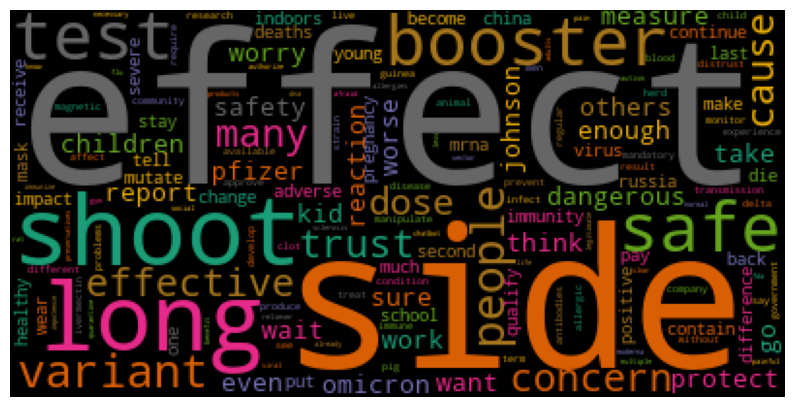

In [27]:
# display the word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(max_words=200, collocations = False,colormap='Dark2').generate(text_new)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('word_cloud.png')
plt.show()

As the word cloud shows, some of the most frequent words include side, effect, booster, shoot, variant, safe, effective, people, test, long, cause, concern, children, trust, dose, dangerous, omicron and so on. 

Do these key words appear together or individually? Let's see the most assicated words in the common questions using bigrams and trigrams respectively. 

In [28]:
# create word tokens
tokenized_words=word_tokenize(text_new)

In [29]:
# display the top 20 bigrams which are most associated
from nltk import BigramAssocMeasures
from nltk import BigramCollocationFinder
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokenized_words)

finder.nbest(bigram_measures.likelihood_ratio,20)

[('side', 'effect'),
 ('omicron', 'variant'),
 ('booster', 'shoot'),
 ('safety', 'measure'),
 ('much', 'pay'),
 ('china', 'russia'),
 ('pay', 'much'),
 ('go', 'back'),
 ('impact', 'pregnancy'),
 ('pregnancy', 'impact'),
 ('qualify', 'qualify'),
 ('continue', 'safety'),
 ('put', 'manipulate'),
 ('wear', 'mask'),
 ('trust', 'china'),
 ('prevent', 'transmission'),
 ('term', 'research'),
 ('see', 'affect'),
 ('russia', 'trust'),
 ('guinea', 'pig')]

It is seen that some most freqent words tend to appear together such as side effect, omicron variant, booster shoot. Since the lemmatization is applied to data cleaning, the word `shoot` is more likely to be `shot` before the lemmatization. This explains why `shoot` is associated with `booster`.

How about the most associated three words? We will find it out using the top 50 trigrams. 

In [30]:
# display the top 50 trigrams which are most associated
from nltk import TrigramAssocMeasures
from nltk import TrigramCollocationFinder
trigram_measures = TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(tokenized_words)

finder.nbest(trigram_measures.likelihood_ratio,50)

[('severe', 'side', 'effect'),
 ('side', 'effect', 'deaths'),
 ('side', 'effect', 'adverse'),
 ('worry', 'side', 'effect'),
 ('effect', 'side', 'effect'),
 ('side', 'effect', 'worse'),
 ('shots', 'side', 'effect'),
 ('common', 'side', 'effect'),
 ('shoot', 'side', 'effect'),
 ('experience', 'side', 'effect'),
 ('side', 'effect', 'common'),
 ('side', 'effect', 'men'),
 ('side', 'effect', 'work'),
 ('report', 'side', 'effect'),
 ('worse', 'side', 'effect'),
 ('get', 'side', 'effect'),
 ('side', 'effect', 'booster'),
 ('side', 'effect', 'children'),
 ('children', 'side', 'effect'),
 ('side', 'effect', 'side'),
 ('side', 'effect', 'get'),
 ('long', 'side', 'effect'),
 ('kid', 'side', 'effect'),
 ('side', 'effect', 'convince'),
 ('others', 'side', 'effect'),
 ('side', 'effect', 'stay'),
 ('manipulate', 'side', 'effect'),
 ('side', 'effect', 'happen'),
 ('result', 'side', 'effect'),
 ('rush', 'side', 'effect'),
 ('flu', 'side', 'effect'),
 ('adults', 'side', 'effect'),
 ('variant', 'omicron'

From the trigrams listed above, we can see some potential reasons for vaccine hesitancy such sever side effects (such as death, flu), side effect on children/kids, side effect on adults, danger of booster shot, high price of vaccine, impact on pregnancy, regular safty measure and so on.

### Deep dive into key topics or main concerns

In the following parts, we will dive deeper into several key words or bigrams identified in previous steps, including:
- side effect
- omicron variant
- booster shot
- people
- children/kids
- trust
- concern

Firstly, let's identify the common questions which contain the key words or bigrams and count the number of expressions by question.

In [31]:
# count the commmon questions containing the key words 'side effect' or 'side effects' and save it into dataframe 'df_intent_se'
df_intent_se=df_intent_clean[(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('side effects'))|(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('side effect'))]
df_intent_se=df_intent_se[['sentence','label']].groupby('label',as_index=False).count()
df_intent_se['key words']='side effect'

#  count the commmon questions containing the key words 'omicron variant' or 'omicron variants' and save it into dataframe 'df_intent_ov'
df_intent_ov=df_intent_clean[(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('omicron variant'))|(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('omicron variants'))]
df_intent_ov=df_intent_ov[['sentence','label']].groupby('label',as_index=False).count()
df_intent_ov['key words']='omicron variant'

#  count the commmon questions containing the key words 'booster shot' or 'booster shots' and save it into dataframe 'df_intent_bs'
df_intent_bs=df_intent_clean[(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('booster shot'))|(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('booster shots'))]
df_intent_bs=df_intent_bs[['sentence','label']].groupby('label',as_index=False).count()
df_intent_bs['key words']='booster shot'

#  count the commmon questions containing the key words 'people' and save it into dataframe 'df_intent_pp'
df_intent_pp=df_intent_clean[(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('people'))]
df_intent_pp=df_intent_pp[['sentence','label']].groupby('label',as_index=False).count()
df_intent_pp['key words']='people'

#  count the commmon questions containing the key words 'children' or 'child' or 'kids' or 'kid' and save it into dataframe 'df_intent_ck'
df_intent_ck=df_intent_clean[(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('children'))|(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('child'))
                             |(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('kids'))|(df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('kid'))]
df_intent_ck=df_intent_ck[['sentence','label']].groupby('label',as_index=False).count()
df_intent_ck['key words']='children/kids'

#  count the commmon questions containing the key words 'trust' and save it into dataframe 'df_intent_tr'
df_intent_tr=df_intent_clean[df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('trust')]
df_intent_tr=df_intent_tr[['sentence','label']].groupby('label',as_index=False).count()
df_intent_tr['key words']='trust'

#  count the commmon questions containing the key words 'concern' and save it into dataframe 'df_intent_co'
df_intent_co=df_intent_clean[df_intent_clean['label'].apply(lambda x: x.lower()).str.contains('concern')]
df_intent_co=df_intent_co[['sentence','label']].groupby('label',as_index=False).count()
df_intent_co['key words']='concern'

# combine the dataframes and save it into 'df_intent_key_words'
df_intent_key_words=pd.concat([df_intent_se,df_intent_ov,df_intent_bs,df_intent_pp,df_intent_ck,df_intent_tr,df_intent_co],axis=0)

In [32]:
# display the first 5 rows
df_intent_key_words.head().style.set_properties(subset=['sentence'], **{'width': '200px'})

,label,sentence,key words
0,Are booster shot side effects worse than those from the second shot?,29,side effect
1,Are the side effects worse for the second shot,37,side effect
2,Are women more likely to get worse side effects than men?,28,side effect
3,Does the vaccine work if I do not experience any side effects?,36,side effect
4,How common are vaccine side effects?,25,side effect


Then we will count the total number of questions and sentences by key words or bigrams and visualise the figures with two bar charts side by side.

In [33]:
# count the total number of sentences by key words and save it info dataframe 'df_intent_kw_sentence'
df_intent_kw_sentence=df_intent_key_words.groupby('key words',as_index=False).agg({'sentence':'sum'}).sort_values(by='sentence',ascending=False)

# count the total number of questions by key words and save it info dataframe 'df_intent_kw_question'
df_intent_kw_question=df_intent_key_words.groupby('key words',as_index=False).agg({'label':'count'}).sort_values(by='label',ascending=False)

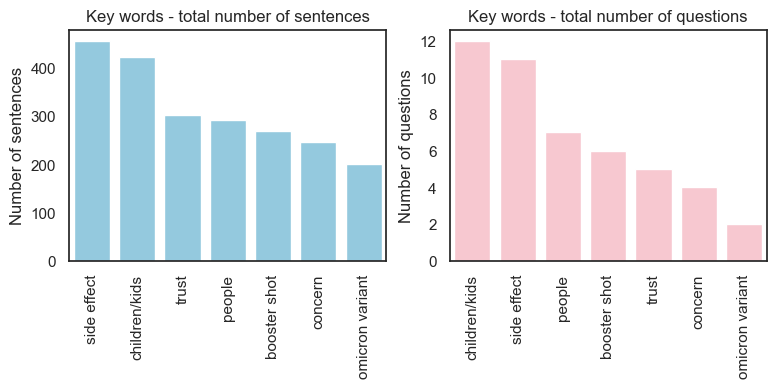

In [34]:
# display the key words with total number of sentences and with total number of questions side by side
fig, axs = plt.subplots(ncols=2, figsize=(9,3))
sns.barplot(data=df_intent_kw_sentence,x='key words',y='sentence',color='skyblue',ax=axs[0])
axs[0].set_ylabel('Number of sentences')
axs[0].set_xlabel('')
axs[0].set_title('Key words - total number of sentences')
axs[0].set_xticklabels(df_intent_kw_sentence['key words'],rotation=90)

sns.barplot(data=df_intent_kw_question,x='key words',y='label',color='pink',ax=axs[1])
axs[1].set_ylabel('Number of questions')
axs[1].set_xlabel('')
axs[1].set_title('Key words - total number of questions')
axs[1].set_xticklabels(df_intent_kw_question['key words'],rotation=90)

plt.show()

As shown in the graphs above, among these seven key words or bigrams, `side effect` and `children/kids` have the highest number of expressions/sentences and common questions. According to the chart on the left, around 1000 expressions in total are related to side effect, children/kids or trust. Some expressions may cover two key words or bigrams at the same time, for example the sentences can talk about the side effects on children/kids. From the chart on the right-hand side, it is seen that over 40 questions out of 181 are relevant to `children/kids`, `side effect`, `people`, `booster shot`, `trust` and `omicron variant`.

To thred some light on the reasons behind COVID-19 vaccine hesitancy, we will take a closer look at the questions containing these key words or bigrams.

**Side effect**

What are some common questions or concerns about side effects?

In [35]:
df_intent_se

,label,sentence,key words
0,Are booster shot side effects worse than those...,29,side effect
1,Are the side effects worse for the second shot,37,side effect
2,Are women more likely to get worse side effect...,28,side effect
3,Does the vaccine work if I do not experience a...,36,side effect
4,How common are vaccine side effects?,25,side effect
5,Side effects and adverse reactions worry me,89,side effect
6,There are many reports of severe side effects ...,85,side effect
7,Vaccine side effects are not getting reported,36,side effect
8,What are the side effect of the vaccine?,30,side effect
9,What are the side effects of booster shots?,36,side effect


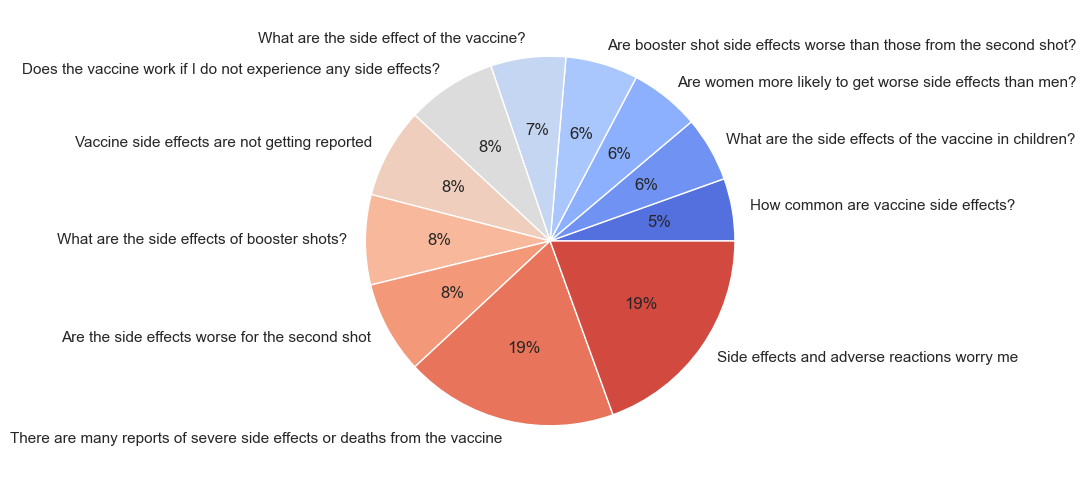

In [36]:
f,ax=plt.subplots(figsize=(6,6))
df_intent_se.sort_values(by='sentence',ascending=True,inplace=True)
# define Seaborn color palette for the pie chart (orange to blue)
colors = sns.color_palette("coolwarm", n_colors=len(df_intent_se))
#create pie chart
plt.pie(df_intent_se['sentence'], labels = df_intent_se['label'], colors = colors, autopct='%.0f%%')
plt.show()

Among the expressions related to side effects, the findings below are revealved from the pie chart:
- 38% mentions the worry about the severe side effects (such as death) or adverse reactions. 
- 22% questions the side effects of the second shot or booster shot
- 12% expresses the concern about the side effects in children or women
- 8% doubts the underreporting of side effects
- the remaining reflects the lack of knowledge in the vaccine such as its side effect, the commonality of side effects and the relationship between vaccine effectiveness and its side effects.



**Children/Kids**

What are the key concerns around children or kids?

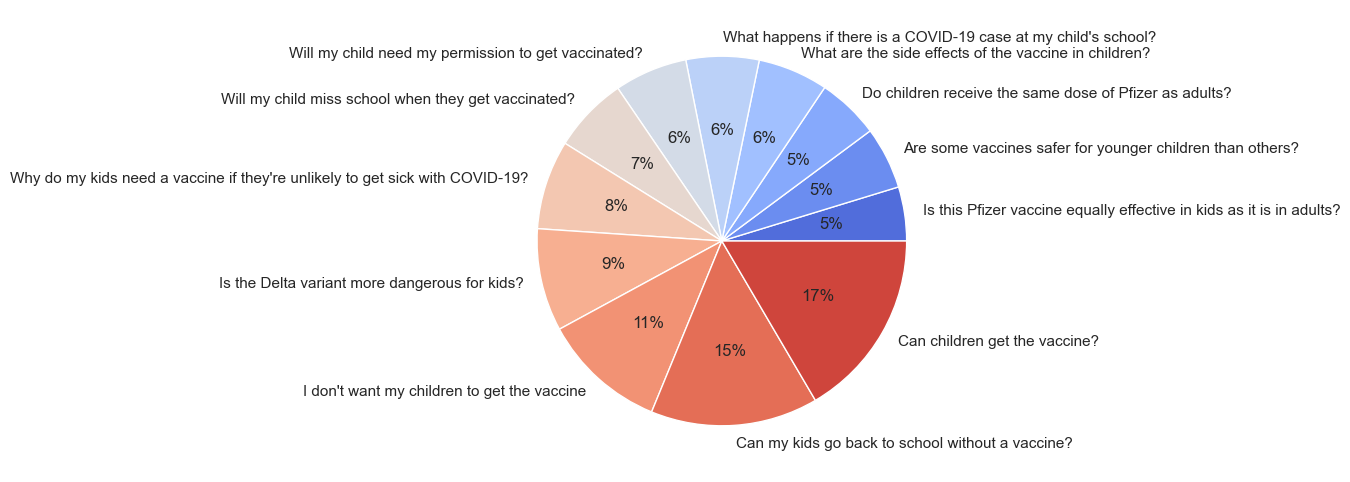

In [37]:
f,ax=plt.subplots(figsize=(6,6))
df_intent_ck.sort_values(by='sentence',ascending=True,inplace=True)
# define Seaborn color palette for the pie chart (orange to blue)
colors = sns.color_palette("coolwarm", n_colors=len(df_intent_ck))
#create pie chart
plt.pie(df_intent_ck['sentence'], labels = df_intent_ck['label'], colors = colors, autopct='%.0f%%')
plt.show()

Based on the pie chart, 11% of expressions shows the unwillingness to get their children vaccinated from the parents' perspective. Some main concerns concentrate on the safety issue of the vaccine, whether the vaccine is compulsory in school, impact of the vaccine on children (such as side effects, missing school), and variances between children and adults in terms of vaccine doses and effectiveness. 

**Trust**

Is the vaccine hesitancy related to trust issue? What type of trust can affect vaccine hesitancy?

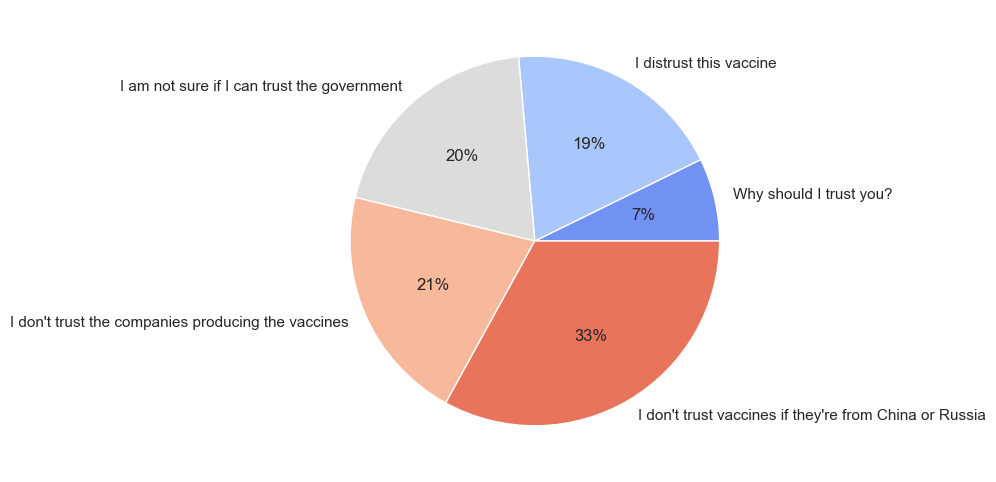

In [38]:
f,ax=plt.subplots(figsize=(6,6))
df_intent_tr.sort_values(by='sentence',ascending=True,inplace=True)
# define Seaborn color palette for the pie chart (orange to blue)
colors = sns.color_palette("coolwarm", n_colors=len(df_intent_tr))
#create pie chart
plt.pie(df_intent_tr['sentence'], labels = df_intent_tr['label'], colors = colors, autopct='%.0f%%')
plt.show()

The chart above indicates several factors can cause distrust of the vaccine including:
- the origin of the vaccine such as China or Russia (33%)
- the companies producing the vaccines (21%)
- the government (20%)
- other reasons(26%)

For the remaining key words or bigrams, their common questions are listed in the table below. 

Several concerns can be seen including the potential risks and side effects of booster shot or other vaccines, effectiveness of vaccines, the impact on the pre-existing condition or medications, lack of understanding in Omicron variant and unclarity about dos and don'ts before and after vaccination.

In [39]:
# display the common questions containing the key words/bigrams including people','concern','booster shot','omicron variant'. 
df_intent_key_words[df_intent_key_words['key words'].isin(['people','concern','booster shot','omicron variant'])].\
reset_index(drop=True).sort_values(by=['key words','sentence'],ascending=[True,False]).style.set_properties(subset=['sentence'], **{'width': '100px'})

,label,sentence,key words
3,Is the booster shot dangerous?,90,booster shot
6,Will I need a booster shot?,61,booster shot
4,What are the side effects of booster shots?,36,booster shot
2,Are booster shot side effects worse than those from the second shot?,29,booster shot
7,Will there be a booster shot for J&J and Moderna?,27,booster shot
5,What is the difference between the third shot and a booster shot?,26,booster shot
18,I'm concerned the vaccine will make me sick.,85,concern
17,I am concerned getting the vaccine because I have a pre-existing condition,67,concern
15,I am concerned I will be a guinea pig,65,concern
16,I am concerned about getting the vaccine because of my medications.,30,concern


## Recommendations
Based on the findings mentioned above, a few suggestions are provided to the public health officials or the government as below:
- Be transparent about the side effects of different vaccines (such as third shot, booster shot) and how they impact different groups (such as children, women etc.);
- Provide learning resouces online or in the community to help people gain a better understanding of vaccines and things relevant to vaccines, for example how long the vaccine is effective, what are the safety measures after vaccination, what are the differences between different type of shot and so on;
- Build stronger trust between the public and the government by reporting the side effects of vaccines with integrity, enhancing the regulations and inspection on the quality of vaccines and other effective measures to rebuild the trust and improve the vaccine acceptance.

## Conclusion
In this notebook, we analysed the dataset of intent expressions to bring insight into the common questions and main concerns about COVID-19 vaccines and dived deep into each of the main concerns to understand the reasons behind vaccine hesitancy. Based on the insight derived from the data analysis, we then recommended several measures to the public health officials and the government to address the key concerns and promote the vaccine acceptance. For the future work, I would like to explore further on the content of expressions with the applications of other techniques such as topic modelling and sentiment analysis to provide additional insight and suggestions. 

## References

Gretz, S., Toledo, A., Friedman, R., Lahav, D., Weeks, R., Sedoc, J., Sangha, P., Katz, Y., & Slonim, N. (2022). Benchmark Data and Evaluation Framework for Intent Discovery Around COVID-19 Vaccine Hesitancy. ArXiv. /abs/2205.11966